In [2]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

import numpy as np
from main_functions.ME_solver import solve_master_equation
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2
import math
from qiskit import generate_preset_pass_manager
from utils.generate_complementary_colors import generate_complementary_colors
import random
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [3]:
def get_populations(n_emitters, result):
    """
    Measures the excited state population of each qubit from a PubResult
    """
    evs = {str(i) : [] for i in range(n_emitters)}
    std_devs = {str(i) : [] for i in range(n_emitters)}

    for k in range(len(result)):
        pub_result = result[k]
        shots = pub_result.data.meas.num_shots
        counts = pub_result.data.meas.get_counts()
        states = [key[(n_emitters):] for key in counts.keys()] # Output states
        coeff = [ np.sqrt(counts[key]/shots) for key in counts.keys()] # Normalized coefficients
        eigenvalues = [1, -1] # Z eigenvalues

        for i in range(n_emitters):

            ev = 0.5*( 1 - sum([ (coeff[j]**2)*eigenvalues[int(states[j][-i-1])] for j in range(len(states)) ]))
            evs[str(i)].append( ev ) # Fix this
            var = ev*( 1 - ev )
            var = max(var, 0.0) #To avoid negative sqrts
            std_devs[str(i)].append(np.sqrt( var / shots )) 
    
    return evs, std_devs

In [7]:
def get_circuit(omega_m, omega_c, g, gamma, kappa, k):

    delta = omega_m - omega_c
    omega_eff =  omega_m + (delta*(g**2))/((0.5*kappa)**2 + delta**2)
    gamma_eff = gamma + (kappa*(g**2))/((0.5*kappa)**2 + delta**2)

    delta_t = Parameter('$t$')/k
    alpha = omega_eff*delta_t
    theta = (((1 - (-delta_t*gamma_eff).exp())**(1/2)).arcsin())*2

    qc = QuantumCircuit(2)
    qc.x(0)
    for _ in range(k):
        qc.rz(alpha, 0)
        qc.cry(theta, 0, 1)
        qc.cx(1, 0)
        qc.reset(1)
        
    qc.measure_all()
    return qc

In [11]:
num_emitters = 1
num_ancilla = 1

omega_m = 1.2
omega_c = 1.1
gamma = 0.8*(10**(-6))
kappa = 0.2
g = 0.03 
a = np.linspace(0, 1, 200)
t = 750*(np.array([x**1.5 for x in a]))
k = 3
shots = 10**3

In [12]:
backend = AerSimulator()
sampler = SamplerV2(mode = backend, options = {'default_shots' : shots})
qc = get_circuit(omega_m, omega_c, g, gamma, kappa, k)
pm = generate_preset_pass_manager(optimization_level=2, backend = AerSimulator())
isa_qc = pm.run(qc)
pubs = [ (isa_qc.decompose(reps = 2), x) for x in t ]

job = sampler.run(pubs)
result = job.result()
evs, std_evs = get_populations(num_emitters, result)

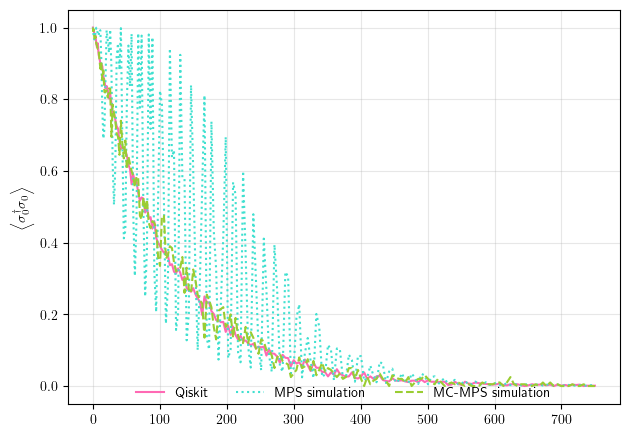

In [17]:
mps_evs = np.load("../datasets/one_emitter_MPS_results.npz")
mcmps_evs = np.load("../datasets/one_emitter_MCMPS_results.npz")

plot_qubits = evs.keys()
colors = generate_complementary_colors(len(plot_qubits), 'neon', 'deeppink')
plt.plot(t, evs['0'], linestyle='solid', color='hotpink', label = 'Qiskit')
plt.plot(t, mps_evs, linestyle='dotted', color='turquoise', label = 'MPS simulation')
plt.plot(t, mcmps_evs, linestyle='dashed', color='yellowgreen', label = 'MC-MPS simulation')

plt.ylabel(f'$\\left< \\sigma^{{\\dagger}}_{{{int(0)}}} \\sigma_{{{int(0)}}} \\right>$')
plt.grid(True, alpha=0.3)


plt.legend(loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout(rect=[0, 0.07, 1, 1])
#plt.savefig('../figs/MPS_comparison_3_emitters', bbox_inches='tight')
plt.show()

In [ ]:
from main_functions.generalized_original_circuit import get_circuit as get_two_emitter_qc

num_emitters = 2

omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*(10**(-6))]*num_emitters
kappa = [0.2]
g = [0.03]*2*(num_emitters-1)
a = np.linspace(0, 1, 100)
t = 750*(np.array([x**1.5 for x in a]))
k = 2
shots = 10**3
initial_excited = ['1']

backend = AerSimulator()
sampler = SamplerV2(mode = backend, options = {'default_shots' : shots})
qc = get_two_emitter_qc(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_excited, k)
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=2, backend = AerSimulator())
isa_qc = pm.run(qc)
pubs = [ (isa_qc.decompose(reps = 2), x) for x in t ]

job = sampler.run(pubs)
result = job.result()
evs, std_evs = get_populations(num_emitters, result)

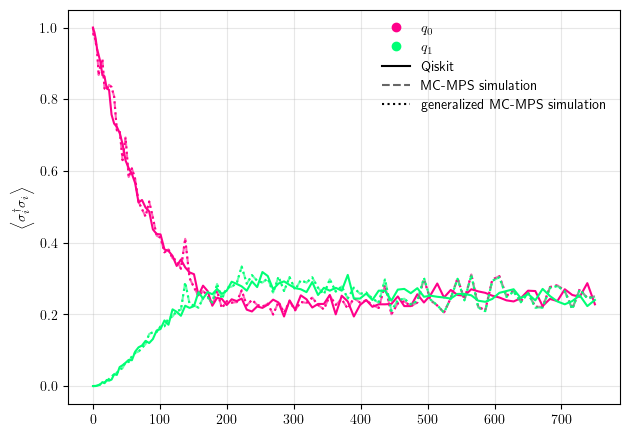

In [15]:
mps_evs = np.load("../datasets/two_emitter_MCMPS_results_k_2_hard_reset.npz")
new_mps_evs = np.load("../datasets/genMCMPS_n_2_k_2.npz")

plot_qubits = ['0', '1']
colors = generate_complementary_colors(len(plot_qubits), 'neon', 'deeppink')

for (idx, q) in enumerate(plot_qubits):
    plt.plot(t, evs[q], linestyle='solid', color=colors[idx])
    plt.plot(t, mps_evs[q], linestyle='dashed', alpha = 0.6, color=colors[idx])
    plt.plot(t, new_mps_evs[q], linestyle='dotted', color=colors[idx])
    plt.plot(np.nan, np.nan, linestyle = 'none', marker = 'o', color = colors[idx], label = f'$q_{{{idx}}}$')    

plt.plot(np.nan, np.nan, linestyle = 'solid', color = 'black', label = 'Qiskit')    
plt.plot(np.nan, np.nan, linestyle = 'dashed', alpha = 0.6, color = 'black', label = 'MC-MPS simulation')    
plt.plot(np.nan, np.nan, linestyle = 'dotted', color = 'black', label = 'generalized MC-MPS simulation')    
plt.ylabel(f'$\\left< \\sigma^{{\\dagger}}_i \\sigma_i \\right>$')
plt.grid(True, alpha=0.3)

plt.legend(frameon=False)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('../figs/comparison_MCMPS_2_emitters_k_2', bbox_inches='tight')
plt.show()

In [4]:
from main_functions.generalized_original_circuit import get_circuit as get_two_emitter_qc

num_emitters = 6

omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*(10**(-6))]*num_emitters
kappa = [0.2]
g = [0.03]*2*(num_emitters-1)
a = np.linspace(0, 1, 100)
t = 750*(np.array([x**1.5 for x in a]))
k = 3
shots = 10**3
initial_excited = ['1', '3', '4']

backend = AerSimulator()
sampler = SamplerV2(mode = backend, options = {'default_shots' : shots})
qc = get_two_emitter_qc(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_excited, k)
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=2, backend = AerSimulator())
isa_qc = pm.run(qc)
pubs = [ (isa_qc.decompose(reps = 2), x) for x in t ]

job = sampler.run(pubs)
result = job.result()
evs, std_evs = get_populations(num_emitters, result)

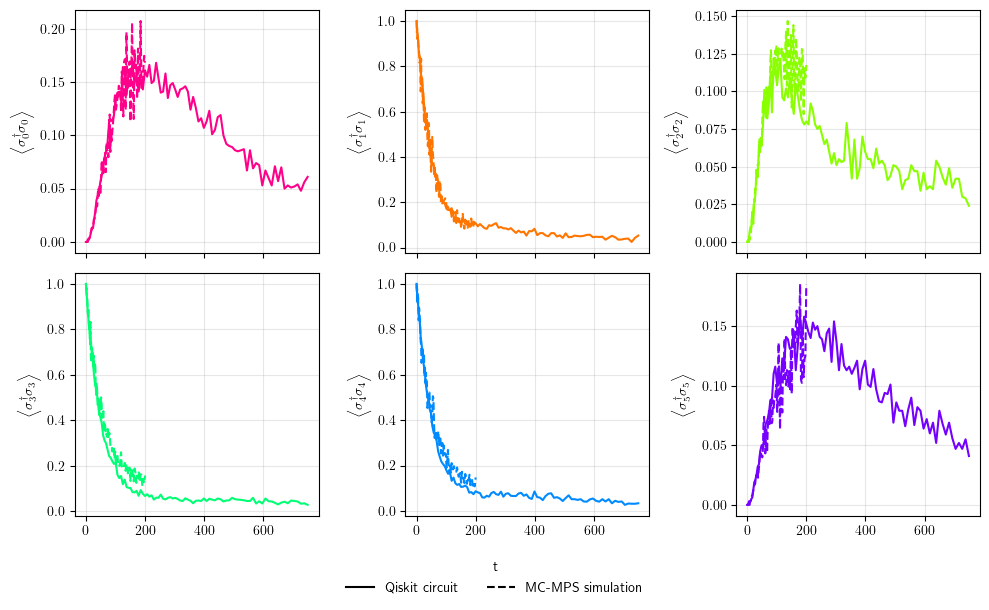

In [9]:
mps_evs = np.load("../datasets/fixing_MCMPS_n_6_k_3.npz")
# qiskit_mps_evs = np.load("../datasets/qiskit_MPS_results.npz", allow_pickle=True)['arr_0'].item()

plot_qubits = evs.keys()
colors = generate_complementary_colors(len(plot_qubits), 'neon', 'deeppink')
#fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

axes = axes.flatten()  
a = np.linspace(0, 1, 100)
other_t = 200*(np.array([x**1.5 for x in a]).ravel())

for i, qubit in enumerate(plot_qubits):
    ax = axes[i]
    color = colors[i]
    ax.plot(t, evs[qubit], linestyle='solid', color=color)
    ax.plot(other_t, mps_evs[qubit], linestyle='dashed', color=color)

    ax.set_ylabel(f'$\\left< \\sigma^{{\\dagger}}_{{{int(qubit)}}} \\sigma_{{{int(qubit)}}} \\right>$')
    ax.grid(True, alpha=0.3)
    # ax.set_yscale('log')

# Shared x label
fig.text(0.5, 0.04, 't', ha='center')

handles = [
    plt.Line2D([], [], linestyle='solid', color='black', label='Qiskit circuit'),
    plt.Line2D([], [], linestyle='dashed', color='black', label='MC-MPS simulation'),
]

fig.legend(handles=handles, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.02))

# plt.xscale('log')
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('../figs/fixing_MC_MPS_n_6_k_3', bbox_inches='tight')
plt.show()